# loading two independent variables

In [2]:
import numpy as np
from qiskit_finance.circuit.library import LogNormalDistribution
# number of qubits per dimension to represent the uncertainty
num_uncertainty_qubits = 3

# parameters for considered random distribution
S = 1.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.04  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)
print(mu)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# map to higher dimensional distribution
# for simplicity assuming dimensions are independent and identically distributed)
dimension = 2
num_qubits = [num_uncertainty_qubits] * dimension
low = low * np.ones(dimension)
high = high * np.ones(dimension)
mu = mu * np.ones(dimension)
cov = sigma**2 * np.eye(dimension) # covariance matrix

# construct circuit
u = LogNormalDistribution(num_qubits=num_qubits, mu=mu, sigma=cov, bounds=list(zip(low, high)))
# u.measure_all()
u.draw()

-0.004383561643835618


┌───────┐
q_0: ┤0      ├
     │       │
q_1: ┤1      ├
     │       │
q_2: ┤2      ├
     │  P(X) │
q_3: ┤3      ├
     │       │
q_4: ┤4      ├
     │       │
q_5: ┤5      ├
     └───────┘

In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer

first_variable_register = QuantumRegister(num_uncertainty_qubits, name='x')
second_variable_register = QuantumRegister(num_uncertainty_qubits, name='y')
second_ancilla_register = QuantumRegister(num_uncertainty_qubits, name='a')
first_classical_register = ClassicalRegister(num_uncertainty_qubits, name='c1')
second_classical_register = ClassicalRegister(num_uncertainty_qubits, name='c2')
third_classical_register = ClassicalRegister(num_uncertainty_qubits, name='c3')

circ = QuantumCircuit(first_variable_register, second_variable_register, second_ancilla_register, first_classical_register, second_classical_register, third_classical_register)
circ.append(u, first_variable_register[:] + second_variable_register[:])
circ.cnot(second_variable_register, second_ancilla_register)
circ.barrier()
# circ.measure(first_variable_register, first_classical_register)
circ.measure(second_variable_register, second_classical_register)
circ.measure(second_ancilla_register, third_classical_register)
circ.draw()

/tmp/ipykernel_3355492/3128409644.py:12: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed in the Qiskit 1.0.0 release. Use QuantumCircuit.cx as direct replacement.
  circ.cnot(second_variable_register, second_ancilla_register)


┌───────┐                ░                   
 x_0: ┤0      ├────────────────░───────────────────
      │       │                ░                   
 x_1: ┤1      ├────────────────░───────────────────
      │       │                ░                   
 x_2: ┤2      ├────────────────░───────────────────
      │  P(X) │                ░ ┌─┐               
 y_0: ┤3      ├──■─────────────░─┤M├───────────────
      │       │  │             ░ └╥┘┌─┐            
 y_1: ┤4      ├──┼────■────────░──╫─┤M├────────────
      │       │  │    │        ░  ║ └╥┘┌─┐         
 y_2: ┤5      ├──┼────┼────■───░──╫──╫─┤M├─────────
      └───────┘┌─┴─┐  │    │   ░  ║  ║ └╥┘┌─┐      
 a_0: ─────────┤ X ├──┼────┼───░──╫──╫──╫─┤M├──────
               └───┘┌─┴─┐  │   ░  ║  ║  ║ └╥┘┌─┐   
 a_1: ──────────────┤ X ├──┼───░──╫──╫──╫──╫─┤M├───
                    └───┘┌─┴─┐ ░  ║  ║  ║  ║ └╥┘┌─┐
 a_2: ───────────────────┤ X ├─░──╫──╫──╫──╫──╫─┤M├
                         └───┘ ░  ║  ║  ║  ║  ║ └╥┘
c1: 3/════════════════════════════╬══╬══╬══╬══╬══╬═
                                  ║  ║  ║  ║  ║  ║ 
c2: 3/════════════════════════════╩══╩══╩══╬══╬══╬═
                                  0  1  2  ║  ║  ║ 
c3: 3/═════════════════════════════════════╩══╩══╩═
                                           0  1  2

In [4]:
job = execute(circ, Aer.get_backend('qasm_simulator'), shots=1000)
counts = job.result().get_counts()
print(counts)

/tmp/ipykernel_3355492/84418813.py:1: DeprecationWarning: The 'qiskit.Aer' entry point is deprecated and will be removed in Qiskit 1.0. You should use 'qiskit_aer.Aer' directly instead.
  job = execute(circ, Aer.get_backend('qasm_simulator'), shots=1000)
/tmp/ipykernel_3355492/84418813.py:1: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  job = execute(circ, Aer.get_backend('qasm_simulator'), shots=1000)


{'000 000 000': 1, '111 111 000': 15, '110 110 000': 31, '010 010 000': 191, '101 101 000': 112, '011 011 000': 361, '001 001 000': 22, '100 100 000': 267}


## Build QFT

In [5]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.quantum_info.operators import Operator


def controlled_rotation_gate(k):
    rotation = np.array(
        [[1, 0], [0, np.exp(2 * np.pi * 1j / 2**k)]], dtype=np.complex128
    )
    rotation_gate = Operator(rotation)
    circuit = QuantumCircuit(1)
    circuit.append(rotation_gate, [0])
    rotation_gate = circuit.to_gate(label="R'{}".format(k))
    controlled_rotation = rotation_gate.control(1)
    return controlled_rotation


def qft_gate(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n, name='QFT')
    for i in range(n):
        circuit.h(i)
        for j in range(i+1, n):
            circuit.append(controlled_rotation_gate(j-i+1), [j, i])
    return circuit

n_qubits = 3

qft_circuit = QuantumCircuit(n_qubits+1, name='QFT')

for i in range(qft_circuit.num_qubits):
    qft_circuit.h(i)
    for j in range(i+1, qft_circuit.num_qubits):
        qft_circuit.append(controlled_rotation_gate(j-i+1), [j, i])
    # qft_circuit.barrier()

qft_circuit.draw()
qft = qft_circuit.to_gate(label='QFT')
inverse_qft_gate = qft.inverse()

# Building Comparator

In [6]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.quantum_info.operators import Operator

def rotation(k):
    return np.array([[1, 0], [0, np.exp(2 * np.pi * 1j / 2**k)]])


def controlled_inverse_rotation_gate(k):
    inverse_rotation = np.array(
        [[1, 0], [0, np.exp(-2 * np.pi * 1j / 2**k)]], dtype=np.complex128
    )
    # print(inverse_rotation)
    inverse_rotation_gate = Operator(inverse_rotation)
    circuit = QuantumCircuit(1)
    circuit.append(inverse_rotation_gate, [0])
    inverse_rotation_gate = circuit.to_gate(label="R'{}".format(k))
    controlled_rotation = inverse_rotation_gate.control(1)
    return controlled_rotation


def build_NMSub(m, n):
    first_number_register = QuantumRegister(n + 1, name="phi(a)")
    second_number_register = QuantumRegister(m, name="b")
    quantum_circuit = QuantumCircuit(first_number_register, second_number_register)
    counter = 1
    for i in reversed(range(1, n + 1)):
        for j in reversed(range(counter)):
            # quantum_circuit.append(
            #     controlled_inverse_rotation_gate(counter - j),
            #     [second_number_register[m - j - 1]] + [first_number_register[i]],
            # )
            quantum_circuit.cp(-2 * np.pi /2**(counter - j), second_number_register[m - j - 1], first_number_register[i])
        if counter < m:
            counter += 1
        quantum_circuit.barrier()
    for j in reversed(range(counter)):
        # quantum_circuit.append(
        #     controlled_inverse_rotation_gate(counter - j + 1),
        #     [second_number_register[m - j - 1]] + [first_number_register[0]],
        # )
        quantum_circuit.cp(-2 * np.pi /2**(counter - j + 1), second_number_register[m - j - 1], first_number_register[0])
    return quantum_circuit


test_circuit = QuantumCircuit(5)
# test_circuit.x([2])
# test_circuit.x([6])
test_circuit.append(build_NMSub(2, 2), range(5))
test_circuit.measure_all()
test_circuit.decompose().draw()

# quantum_circuit = build_NMSub(3, 3)
# quantum_circuit.draw()
# quantum_circuit.measure_all()

░                    ░                      ░ ┌─┐            
   q_0: ─────────░────────────────────░──■─────────■─────────░─┤M├────────────
                 ░                    ░  │         │         ░ └╥┘┌─┐         
   q_1: ─────────░──■───────■─────────░──┼─────────┼─────────░──╫─┤M├─────────
                 ░  │       │         ░  │         │         ░  ║ └╥┘┌─┐      
   q_2: ─■───────░──┼───────┼─────────░──┼─────────┼─────────░──╫──╫─┤M├──────
         │       ░  │P(-π)  │         ░  │P(-π/2)  │         ░  ║  ║ └╥┘┌─┐   
   q_3: ─┼───────░──■───────┼─────────░──■─────────┼─────────░──╫──╫──╫─┤M├───
         │P(-π)  ░          │P(-π/2)  ░            │P(-π/4)  ░  ║  ║  ║ └╥┘┌─┐
   q_4: ─■───────░──────────■─────────░────────────■─────────░──╫──╫──╫──╫─┤M├
                 ░                    ░                      ░  ║  ║  ║  ║ └╥┘
meas: 5/════════════════════════════════════════════════════════╩══╩══╩══╩══╩═
                                                                0  1  2  3  4

In [7]:
job = execute(test_circuit, Aer.get_backend('aer_simulator'), shots=1000)
results = job.result()
counts = results.get_counts()
print(counts)

{'00000': 1000}


/tmp/ipykernel_3355492/741198821.py:1: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  job = execute(test_circuit, Aer.get_backend('aer_simulator'), shots=1000)


In [8]:
# test QFT
from qiskit.circuit.library import QFT
circuit = QuantumCircuit(3)
# qft = QFT(3)
qft = qft_gate(3)
inverse_qft = qft.inverse()

circuit.x([1])
circuit.x([2])
circuit.append(qft, range(3))
# circuit.append(inverse_qft, range(3))
circuit.measure_all()


/tmp/ipykernel_3355492/2512446767.py:1: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  job = execute(circuit, Aer.get_backend('aer_simulator'), shots=1000)


{'101': 137, '010': 118, '000': 119, '111': 120, '011': 138, '110': 126, '100': 109, '001': 133}


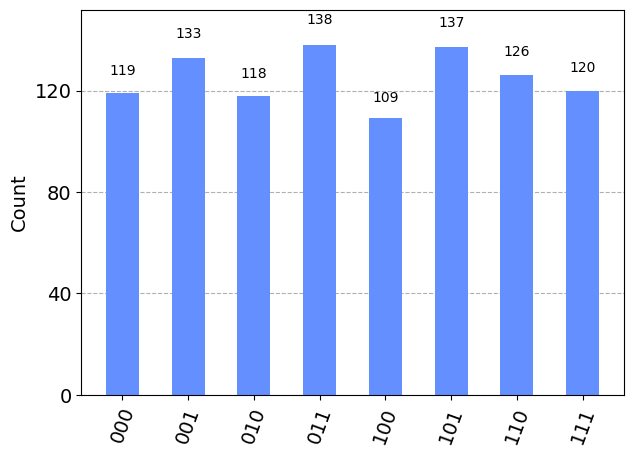

In [9]:
job = execute(circuit, Aer.get_backend('aer_simulator'), shots=1000)
results = job.result()
counts = results.get_counts()
print(counts)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [10]:
def build_NMAdd(m, n):
    first_number_register = QuantumRegister(n, name='phi(a)')
    second_number_register = QuantumRegister(m+1, name='b')
    quantum_circuit = QuantumCircuit(first_number_register, second_number_register, name='NMAdd')
    counter = 1
    for i in range(0, m):
        for j in range(counter):
            # print(i, j)
            quantum_circuit.cp(2*np.pi/2**(counter-j), first_number_register[j], second_number_register[i])
            # quantum_circuit.append(controlled_inverse_rotation_gate(j+1), [second_number_register[m-j-1]]+ [first_number_register[i]])
        if counter < n:
            counter += 1
        quantum_circuit.barrier()
    for j in range(counter):
        quantum_circuit.cp(2*np.pi/2**(j+2), first_number_register[n-j-1], second_number_register[-1])
        # quantum_circuit.append(controlled_inverse_rotation_gate(j+2), [first_number_register[n-j-1]]+ [second_number_register[0]])
        
    return quantum_circuit

def build_QNMAdd(m, n):
    carry_register = QuantumRegister(1, name='c')
    first_number_register = QuantumRegister(n, name='a')
    second_number_register = QuantumRegister(m, name='b')
    quantum_circuit = QuantumCircuit(first_number_register, second_number_register, carry_register, name='QNMAdd')
    
    quantum_circuit.ccx(first_number_register[-1], second_number_register[-1], carry_register[0], ctrl_state='10')
    quantum_circuit.ccx(first_number_register[-1], second_number_register[-1], carry_register[0], ctrl_state='01')

    # quantum_circuit.barrier()
    qft = QFT(n+1, do_swaps=False)
    nmSub = build_NMSub(m, n)
    inverse_qft = qft.inverse()
    quantum_circuit.append(qft, second_number_register[:]+carry_register[:])
    quantum_circuit.append(nmSub, first_number_register[:]+ second_number_register[:]+carry_register[:])
    quantum_circuit.append(inverse_qft, second_number_register[:]+carry_register[:])
    return quantum_circuit

In [11]:
# test QNMADD
def loadNumber(circ: QuantumCircuit, register: QuantumRegister, number: int):
    number_in_binary = '0'*(register.size - len(bin(number)[2:])) + bin(number)[2:]
    print(number_in_binary)
    for i in range(len(number_in_binary)):
        if number_in_binary[::-1][i] == '1':
            circ.x(register[i])

def process_counts(counts):
    key = list(counts.keys())[0]
    key_parts = key.split(' ')
    first_num = int(key_parts[0], 2)
    second_num = int(key_parts[1], 2)
    return first_num, second_num

bit_length = 3
for first_num in range(2**bit_length):
    for second_num in range(2**bit_length):
        carry_register = QuantumRegister(1, name="c")
        first_register = QuantumRegister(bit_length, name="a")
        second_register = QuantumRegister(bit_length, name="b")
        first_register_results = ClassicalRegister(bit_length, name="a_results")
        second_register_results = ClassicalRegister(bit_length+1, name="b_results")

        test_circuit = QuantumCircuit(first_register, second_register,carry_register, first_register_results, second_register_results)

        loadNumber(test_circuit, first_register, first_num)
        loadNumber(test_circuit, second_register, second_num)

        test_circuit.append(build_QNMAdd(bit_length, bit_length), first_register[:] + second_register[:]+ carry_register[:])
        test_circuit.measure(first_register, first_register_results)
        test_circuit.measure(second_register[:]+ carry_register[:], second_register_results)
        job = execute(test_circuit, Aer.get_backend('aer_simulator'), shots=1000)
        results = job.result()
        counts = results.get_counts()
        print("num 1: {}, num 2: {}, result: {}, processed: {}".format(first_num, second_num, counts, process_counts(counts)))

000
000
num 1: 0, num 2: 0, result: {'1011 000': 17, '1111 000': 105, '0011 000': 9, '0101 000': 17, '1101 000': 19, '0001 000': 101, '1001 000': 106, '0111 000': 104, '0000 000': 242, '1000 000': 280}, processed: (11, 0)
000
001
num 1: 0, num 2: 1, result: {'1110 000': 20, '0100 000': 17, '0000 000': 96, '1000 000': 113, '1010 000': 110, '1100 000': 16, '0110 000': 15, '0001 000': 251, '1001 000': 244, '0010 000': 118}, processed: (14, 0)
000
010
num 1: 0, num 2: 2, result: {'0111 000': 19, '1011 000': 112, '1111 000': 14, '1010 000': 281, '1101 000': 21, '0101 000': 15, '0011 000': 87, '1001 000': 102, '0001 000': 118, '0010 000': 231}, processed: (7, 0)
000
011
num 1: 0, num 2: 3, result: {'1110 000': 23, '1000 000': 16, '0000 000': 15, '1100 000': 102, '0110 000': 19, '0100 000': 99, '0010 000': 120, '1010 000': 113, '0011 000': 251, '1011 000': 242}, processed: (14, 0)
000
100
num 1: 0, num 2: 4, result: {'0001 000': 15, '1001 000': 18, '1111 000': 22, '0011 000': 104, '0101 000':

/tmp/ipykernel_3355492/3076416369.py:33: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  job = execute(test_circuit, Aer.get_backend('aer_simulator'), shots=1000)


num 1: 0, num 2: 7, result: {'1100 000': 20, '1110 000': 115, '0010 000': 13, '1010 000': 22, '1111 000': 251, '0100 000': 14, '0111 000': 269, '1000 000': 103, '0000 000': 87, '0110 000': 106}, processed: (12, 0)
001
000
num 1: 1, num 2: 0, result: {'1100 001': 20, '0010 001': 20, '0100 001': 20, '1010 001': 22, '1000 001': 110, '0000 001': 133, '1110 001': 93, '1111 001': 230, '0111 001': 241, '0110 001': 111}, processed: (12, 1)
001
001
num 1: 1, num 2: 1, result: {'1101 001': 27, '0101 001': 15, '0011 001': 19, '1111 001': 105, '0111 001': 116, '0001 001': 100, '1001 001': 117, '0000 001': 232, '1000 001': 253, '1011 001': 16}, processed: (13, 1)
001
010
num 1: 1, num 2: 2, result: {'0110 001': 11, '1110 001': 23, '1000 001': 96, '0000 001': 109, '1100 001': 14, '0010 001': 117, '0100 001': 21, '1010 001': 99, '1001 001': 241, '0001 001': 269}, processed: (6, 1)
001
011
num 1: 1, num 2: 3, result: {'1011 001': 101, '0111 001': 17, '0001 001': 96, '1001 001': 110, '1101 001': 24, '0

In [12]:
from qiskit.circuit.library import QFT
def build_NMSub(m, n):
    first_number_register = QuantumRegister(n, name='phi(a)')
    second_number_register = QuantumRegister(m+1, name='b')
    quantum_circuit = QuantumCircuit(first_number_register, second_number_register, name='NMSub')
    counter = 1
    for i in range(0, m):
        for j in range(counter):
            # print(i, j)
            quantum_circuit.cp(-2*np.pi/2**(counter-j), first_number_register[j], second_number_register[i])
            # quantum_circuit.append(controlled_inverse_rotation_gate(j+1), [second_number_register[m-j-1]]+ [first_number_register[i]])
        if counter < n:
            counter += 1
        quantum_circuit.barrier()
    for j in range(counter):
        quantum_circuit.cp(-2*np.pi/2**(j+2), first_number_register[n-j-1], second_number_register[-1])
        # quantum_circuit.append(controlled_inverse_rotation_gate(j+2), [first_number_register[n-j-1]]+ [second_number_register[0]])
        
    return quantum_circuit

n= 3
m = 3

carry_register = QuantumRegister(1, name='c')
first_number_register = QuantumRegister(n, name='a')
second_number_register = QuantumRegister(m, name='b')
test_circuit = QuantumCircuit(first_number_register, second_number_register, carry_register)
test_circuit.append(build_NMSub(m, n), first_number_register[:] + second_number_register[:]+carry_register[:])
test_circuit.decompose().draw()




░                    ░                              ░           »
a_0: ─■───────░──■─────────────────░──■───────────────────────────░───────────»
      │       ░  │                 ░  │                           ░           »
a_1: ─┼───────░──┼─────────■───────░──┼─────────■─────────────────░───────────»
      │       ░  │         │       ░  │         │                 ░           »
a_2: ─┼───────░──┼─────────┼───────░──┼─────────┼─────────■───────░──■────────»
      │P(-π)  ░  │         │       ░  │         │         │       ░  │        »
b_0: ─■───────░──┼─────────┼───────░──┼─────────┼─────────┼───────░──┼────────»
              ░  │P(-π/2)  │P(-π)  ░  │         │         │       ░  │        »
b_1: ─────────░──■─────────■───────░──┼─────────┼─────────┼───────░──┼────────»
              ░                    ░  │P(-π/4)  │P(-π/2)  │P(-π)  ░  │        »
b_2: ─────────░────────────────────░──■─────────■─────────■───────░──┼────────»
              ░                    ░                              ░  │P(-π/2) »
  c: ─────────░────────────────────░──────────────────────────────░──■────────»
              ░                    ░                              ░           »
«                         
«a_0: ───────────■────────
«                │        
«a_1: ─■─────────┼────────
«      │         │        
«a_2: ─┼─────────┼────────
«      │         │        
«b_0: ─┼─────────┼────────
«      │         │        
«b_1: ─┼─────────┼────────
«      │         │        
«b_2: ─┼─────────┼────────
«      │P(-π/4)  │P(-π/8) 
«  c: ─■─────────■────────
«

In [13]:
from qiskit.circuit.library import QFT
# def build_NMSub(m, n):
#     first_number_register = QuantumRegister(n+1, name='phi(a)')
#     second_number_register = QuantumRegister(m, name='b')
#     quantum_circuit = QuantumCircuit(first_number_register, second_number_register)
#     counter = 1
#     for i in reversed(range(1, n+1)):
#         for j in range(counter):
#             # print(i, j)
#             quantum_circuit.append(controlled_inverse_rotation_gate(j+1), [second_number_register[m-j-1]]+ [first_number_register[i]])
#         if counter < m:
#             counter += 1
#         # quantum_circuit.barrier()
#     for j in range(counter):
#         quantum_circuit.append(controlled_inverse_rotation_gate(j+2), [second_number_register[m-j-1]]+ [first_number_register[0]])
#     return quantum_circuit.to_gate(label="NMSub")


def build_QNMSub(m, n):
    carry_register = QuantumRegister(1, name='c')
    first_number_register = QuantumRegister(n, name='a')
    second_number_register = QuantumRegister(m, name='b')
    quantum_circuit = QuantumCircuit(first_number_register, second_number_register, carry_register, name='QNMSub')
    
    quantum_circuit.ccx(first_number_register[-1], second_number_register[-1], carry_register[0], ctrl_state='10')
    quantum_circuit.ccx(first_number_register[-1], second_number_register[-1], carry_register[0], ctrl_state='01')

    # quantum_circuit.barrier()
    qft = QFT(n+1, do_swaps=False)
    nmSub = build_NMSub(m, n)
    inverse_qft = qft.inverse()
    quantum_circuit.append(qft, second_number_register[:]+carry_register[:])
    quantum_circuit.append(nmSub, first_number_register[:]+ second_number_register[:]+carry_register[:])
    quantum_circuit.append(inverse_qft, second_number_register[:]+carry_register[:])
    return quantum_circuit

m = 3
n = 3
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer

carry_register = QuantumRegister(1, name='c')
first_number_register = QuantumRegister(n, name='a')
second_number_register = QuantumRegister(m, name='b')
classical_register = ClassicalRegister(n+1, name='classical')
test_circuit = QuantumCircuit(first_number_register, second_number_register, carry_register, classical_register)
# test_circuit = QuantumCircuit(carry_register, first_number_register, second_number_register, classical_register)
qnmSub = build_QNMSub(m, n)

# load numbers
test_circuit.x(first_number_register[1])
test_circuit.x(second_number_register[1])
test_circuit.barrier()

test_circuit.append(qnmSub,  first_number_register[:] + second_number_register[:]+carry_register[:])
test_circuit.measure(second_number_register[:]+carry_register[:], classical_register[:])
test_circuit.decompose().draw()


    

░                   ┌────────┐                     
        a_0: ──────────────░───────────────────┤0       ├─────────────────────
             ┌───────────┐ ░                   │        │                     
        a_1: ┤ U3(π,0,π) ├─░───────────────────┤1       ├─────────────────────
             └───────────┘ ░                   │        │                     
        a_2: ──────────────░───o────■──────────┤2       ├─────────────────────
                           ░   │    │  ┌──────┐│        │┌───────┐┌─┐         
        b_0: ──────────────░───┼────┼──┤0     ├┤3 NMSub ├┤0      ├┤M├─────────
             ┌───────────┐ ░   │    │  │      ││        ││       │└╥┘┌─┐      
        b_1: ┤ U3(π,0,π) ├─░───┼────┼──┤1     ├┤4       ├┤1      ├─╫─┤M├──────
             └───────────┘ ░   │    │  │  QFT ││        ││  IQFT │ ║ └╥┘┌─┐   
        b_2: ──────────────░───■────o──┤2     ├┤5       ├┤2      ├─╫──╫─┤M├───
                           ░ ┌─┴─┐┌─┴─┐│      ││        ││       │ ║  ║ └╥┘┌─┐
          c: ──────────────░─┤ X ├┤ X ├┤3     ├┤6       ├┤3      ├─╫──╫──╫─┤M├
                           ░ └───┘└───┘└──────┘└────────┘└───────┘ ║  ║  ║ └╥┘
classical: 4/══════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                   0  1  2  3

{'0000': 1000}


/tmp/ipykernel_3355492/3112060910.py:1: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  job = execute(test_circuit, Aer.get_backend('aer_simulator'), shots=1000)


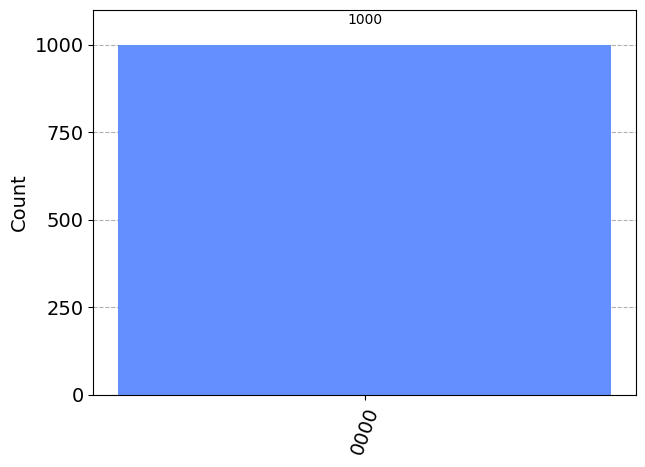

In [14]:
job = execute(test_circuit, Aer.get_backend('aer_simulator'), shots=1000)
results = job.result()
counts = results.get_counts()
print(counts)
# print(counts)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

# test QMNSub

In [15]:
bit_length = 3
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer

def loadNumber(circ: QuantumCircuit, register: QuantumRegister, number: int):
    number_in_binary = '0'*(register.size - len(bin(number)[2:])) + bin(number)[2:]
    print(number_in_binary)
    for i in range(len(number_in_binary)):
        if number_in_binary[::-1][i] == '1':
            circ.x(register[i])

for num_1 in range(2**bit_length):
    for num_2 in range(2**bit_length):
        carry_register = QuantumRegister(1, name='c')
        first_number_register = QuantumRegister(bit_length, name='a')
        second_number_register = QuantumRegister(bit_length, name='b')
        classical_register = ClassicalRegister(bit_length+1, name='classical')
        test_circuit = QuantumCircuit(first_number_register, second_number_register, carry_register, classical_register)
        # test_circuit = QuantumCircuit(carry_register, first_number_register, second_number_register, classical_register)
        qnmSub = build_QNMSub(bit_length, bit_length)
        
        loadNumber(test_circuit, first_number_register, num_1)
        loadNumber(test_circuit, second_number_register, num_2)

        # load numbers
        test_circuit.x(first_number_register[1])
        test_circuit.x(second_number_register[1])
        test_circuit.barrier()

        test_circuit.append(qnmSub,  first_number_register[:] + second_number_register[:]+carry_register[:])
        test_circuit.measure(second_number_register[:]+carry_register[:], classical_register[:])
        test_circuit.decompose().draw()

000
000
000
001
000
010
000
011
000
100
000
101
000
110
000
111
001
000
001
001
001
010
001
011
001
100
001
101
001
110
001
111
010
000
010
001
010
010
010
011
010
100
010
101
010
110
010
111
011
000
011
001
011
010
011
011
011
100
011
101
011
110
011
111
100
000
100
001
100
010
100
011
100
100
100
101
100
110
100
111
101
000
101
001
101
010
101
011
101
100
101
101
101
110
101
111
110
000
110
001
110
010
110
011
110
100
110
101
110
110
110
111
111
000
111
001
111
010
111
011
111
100
111
101
111
110
111
111


In [16]:
from qiskit.circuit.library import MCXGate
def QComp(n,m):
    carry_register = QuantumRegister(1, name='c')
    first_number_register = QuantumRegister(n, name='a')
    second_number_register = QuantumRegister(m, name='b')
    ancilla_register = QuantumRegister(3, name='ancilla')
    circuit = QuantumCircuit(first_number_register, second_number_register, carry_register, ancilla_register, name='QComp')
    qnmsub = build_QNMSub(m, n)
    circuit.append(qnmsub, first_number_register[:] + second_number_register[:]+ carry_register[:])
    circuit.cx(carry_register[:], ancilla_register[0], ctrl_state=0)
    circuit.cx(carry_register[:], ancilla_register[1])
    mcx = MCXGate(num_ctrl_qubits=n+1, ctrl_state='0'*(n+1))
    circuit.append(mcx, carry_register[:]+ second_number_register[:]+ [ancilla_register[0]])
    circuit.append(mcx, carry_register[:]+ second_number_register[:]+ [ancilla_register[2]])
    return circuit


carry_register = QuantumRegister(1, name='c')
first_number_register = QuantumRegister(3, name='b')
second_number_register = QuantumRegister(3, name='a')
ancilla_register = QuantumRegister(3, name='ancilla')
ancilla_measurement = ClassicalRegister(3, name='compare')
work_register_measurement = ClassicalRegister(7, name='work')
test_circuit = QuantumCircuit(first_number_register, second_number_register,carry_register, ancilla_register, ancilla_measurement, work_register_measurement)

test_circuit.x(first_number_register[0])
test_circuit.x(second_number_register[1])

test_circuit.append(QComp(3,3),  first_number_register[:] + second_number_register[:] + carry_register[:] + ancilla_register[:])
test_circuit.barrier()
test_circuit.measure(ancilla_register[:], ancilla_measurement)
# test_circuit.measure(first_number_register[:]+ second_number_register[:]+ carry_register[:], work_register_measurement)
test_circuit.decompose().draw()


┌───────────┐┌─────────┐                     ░          
      b_0: ┤ U3(π,0,π) ├┤0        ├─────────────────────░──────────
           └───────────┘│         │                     ░          
      b_1: ─────────────┤1        ├─────────────────────░──────────
                        │         │                     ░          
      b_2: ─────────────┤2        ├─────────────────────░──────────
                        │         │                     ░          
      a_0: ─────────────┤3 QNMSub ├────────────o────o───░──────────
           ┌───────────┐│         │            │    │   ░          
      a_1: ┤ U3(π,0,π) ├┤4        ├────────────o────o───░──────────
           └───────────┘│         │            │    │   ░          
      a_2: ─────────────┤5        ├────────────o────o───░──────────
                        │         │            │    │   ░          
        c: ─────────────┤6        ├──o────■────o────o───░──────────
                        └─────────┘┌─┴─┐  │  ┌─┴─┐  │   ░ ┌─┐      
ancilla_0: ────────────────────────┤ X ├──┼──┤ X ├──┼───░─┤M├──────
                                   └───┘┌─┴─┐└───┘  │   ░ └╥┘┌─┐   
ancilla_1: ─────────────────────────────┤ X ├───────┼───░──╫─┤M├───
                                        └───┘     ┌─┴─┐ ░  ║ └╥┘┌─┐
ancilla_2: ───────────────────────────────────────┤ X ├─░──╫──╫─┤M├
                                                  └───┘ ░  ║  ║ └╥┘
compare: 3/════════════════════════════════════════════════╩══╩══╩═
                                                           0  1  2 
   work: 7/════════════════════════════════════════════════════════

{'0000000 001': 1000}


/tmp/ipykernel_3355492/3112060910.py:1: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  job = execute(test_circuit, Aer.get_backend('aer_simulator'), shots=1000)


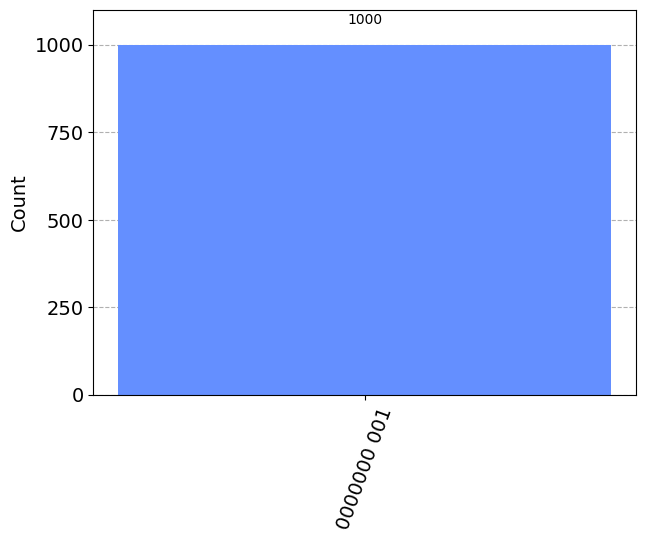

In [17]:
job = execute(test_circuit, Aer.get_backend('aer_simulator'), shots=1000)
results = job.result()
counts = results.get_counts()
print(counts)
# print(counts)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

# Test comparator


In [18]:
def loadNumber(circ: QuantumCircuit, register: QuantumRegister, number: int):
    number_in_binary = '0'*(register.size - len(bin(number)[2:])) + bin(number)[2:]
    for i in range(len(number_in_binary)):
        if number_in_binary[::-1][i] == '1':
            circ.x(register[i])



bit_length = 4
# num_1_list = list(range(2**(bit_length-1)))
num_1_list = [7]
num_2_list = [7]
# num_2_list = list(range(2**(bit_length-1)))
for num_1 in num_1_list:
    for num_2 in num_2_list:
        carry_register = QuantumRegister(1, name="c")
        first_number_register = QuantumRegister(bit_length, name="b")
        second_number_register = QuantumRegister(bit_length, name="a")
        
        ancilla_register = QuantumRegister(3, name="ancilla")
        ancilla_measurement = ClassicalRegister(3, name="compare")
        test_circuit = QuantumCircuit(
            first_number_register,
            second_number_register,
            carry_register,
            ancilla_register,
            ancilla_measurement,
        )
        loadNumber(test_circuit, first_number_register, num_1)
        loadNumber(test_circuit, second_number_register, num_2)

        test_circuit.append(
            QComp(bit_length, bit_length),
            first_number_register[:]
            + second_number_register[:]
            + carry_register[:]
            + ancilla_register[:],
        )
        
        test_circuit.measure(ancilla_register[:], ancilla_measurement)
        job = execute(test_circuit, Aer.get_backend("aer_simulator"), shots=1000)
        results = job.result()
        counts = results.get_counts()
        key = list(counts.keys())[0]
        if key == "100":
            print("{} = {}: ".format(num_1, num_2), num_1 == num_2)
        elif key == "010":
            print("{} > {}: ".format(num_1, num_2), num_1 > num_2)
        elif key == "001":
            print("{} < {}: ".format(num_1, num_2), num_1 < num_2)

test_circuit.draw()

/tmp/ipykernel_3355492/356110930.py:41: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  job = execute(test_circuit, Aer.get_backend("aer_simulator"), shots=1000)


7 = 7:  True


┌───┐┌─────────┐         
      b_0: ┤ X ├┤0        ├─────────
           ├───┤│         │         
      b_1: ┤ X ├┤1        ├─────────
           ├───┤│         │         
      b_2: ┤ X ├┤2        ├─────────
           └───┘│         │         
      b_3: ─────┤3        ├─────────
           ┌───┐│         │         
      a_0: ┤ X ├┤4        ├─────────
           ├───┤│         │         
      a_1: ┤ X ├┤5        ├─────────
           ├───┤│   QComp │         
      a_2: ┤ X ├┤6        ├─────────
           └───┘│         │         
      a_3: ─────┤7        ├─────────
                │         │         
        c: ─────┤8        ├─────────
                │         │┌─┐      
ancilla_0: ─────┤9        ├┤M├──────
                │         │└╥┘┌─┐   
ancilla_1: ─────┤10       ├─╫─┤M├───
                │         │ ║ └╥┘┌─┐
ancilla_2: ─────┤11       ├─╫──╫─┤M├
                └─────────┘ ║  ║ └╥┘
compare: 3/═════════════════╩══╩══╩═
                            0  1  2

# Add back

In [19]:
from qiskit.circuit.library import DraperQFTAdder
bit_length = 3

carry_register = QuantumRegister(1, name="c")
second_carry_register = QuantumRegister(1, name="c'")
first_number_register = QuantumRegister(bit_length, name="a")
second_number_register = QuantumRegister(bit_length, name="b")
ancilla_register = QuantumRegister(3, name="ancilla")
first_number_measurement = ClassicalRegister(bit_length, name="a_results")
second_number_measurement = ClassicalRegister(bit_length, name="b_results")
carry_measurement = ClassicalRegister(1, name="c_results")

test_circuit = QuantumCircuit(
    first_number_register,
    second_number_register,
    carry_register,
    second_carry_register,
    ancilla_register,
    first_number_measurement,
    second_number_measurement,
    carry_measurement,
)


test_circuit.x(first_number_register[1])
test_circuit.x(second_number_register[0])
test_circuit.barrier()

test_circuit.append(
    QComp(bit_length, bit_length),
    first_number_register[:]
    + second_number_register[:]
    + carry_register[:]
    + ancilla_register[:],
)
test_circuit.barrier()
adder = DraperQFTAdder(bit_length, kind="half")
print(adder.num_qubits)
test_circuit.append(
    adder, first_number_register[:] + second_number_register[:] + second_carry_register[:]
)
# test_circuit.measure(first_number_register[:] + second_number_register[:] + carry_register[:], work_register_measurement[:])
test_circuit.measure(first_number_register[:], first_number_measurement[:])
test_circuit.measure(second_number_register[:], second_number_measurement[:])
# test_circuit.measure(carry_register[:], carry_measurement[:])

test_circuit.draw()

7


░ ┌────────┐ ░ ┌─────────────────┐┌─┐               
        a_0: ──────░─┤0       ├─░─┤0                ├┤M├───────────────
             ┌───┐ ░ │        │ ░ │                 │└╥┘┌─┐            
        a_1: ┤ X ├─░─┤1       ├─░─┤1                ├─╫─┤M├────────────
             └───┘ ░ │        │ ░ │                 │ ║ └╥┘┌─┐         
        a_2: ──────░─┤2       ├─░─┤2                ├─╫──╫─┤M├─────────
             ┌───┐ ░ │        │ ░ │                 │ ║  ║ └╥┘┌─┐      
        b_0: ┤ X ├─░─┤3       ├─░─┤3                ├─╫──╫──╫─┤M├──────
             └───┘ ░ │        │ ░ │  DraperQFTAdder │ ║  ║  ║ └╥┘┌─┐   
        b_1: ──────░─┤4       ├─░─┤4                ├─╫──╫──╫──╫─┤M├───
                   ░ │        │ ░ │                 │ ║  ║  ║  ║ └╥┘┌─┐
        b_2: ──────░─┤5 QComp ├─░─┤5                ├─╫──╫──╫──╫──╫─┤M├
                   ░ │        │ ░ │                 │ ║  ║  ║  ║  ║ └╥┘
          c: ──────░─┤6       ├─░─┤                 ├─╫──╫──╫──╫──╫──╫─
                   ░ │        │ ░ │                 │ ║  ║  ║  ║  ║  ║ 
         c': ──────░─┤        ├─░─┤6                ├─╫──╫──╫──╫──╫──╫─
                   ░ │        │ ░ └─────────────────┘ ║  ║  ║  ║  ║  ║ 
  ancilla_0: ──────░─┤7       ├─░─────────────────────╫──╫──╫──╫──╫──╫─
                   ░ │        │ ░                     ║  ║  ║  ║  ║  ║ 
  ancilla_1: ──────░─┤8       ├─░─────────────────────╫──╫──╫──╫──╫──╫─
                   ░ │        │ ░                     ║  ║  ║  ║  ║  ║ 
  ancilla_2: ──────░─┤9       ├─░─────────────────────╫──╫──╫──╫──╫──╫─
                   ░ └────────┘ ░                     ║  ║  ║  ║  ║  ║ 
a_results: 3/═════════════════════════════════════════╩══╩══╩══╬══╬══╬═
                                                      0  1  2  ║  ║  ║ 
b_results: 3/══════════════════════════════════════════════════╩══╩══╩═
                                                               0  1  2 
c_results: 1/══════════════════════════════════════════════════════════

/tmp/ipykernel_3355492/3112060910.py:1: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  job = execute(test_circuit, Aer.get_backend('aer_simulator'), shots=1000)


{'0 001 010': 1000}


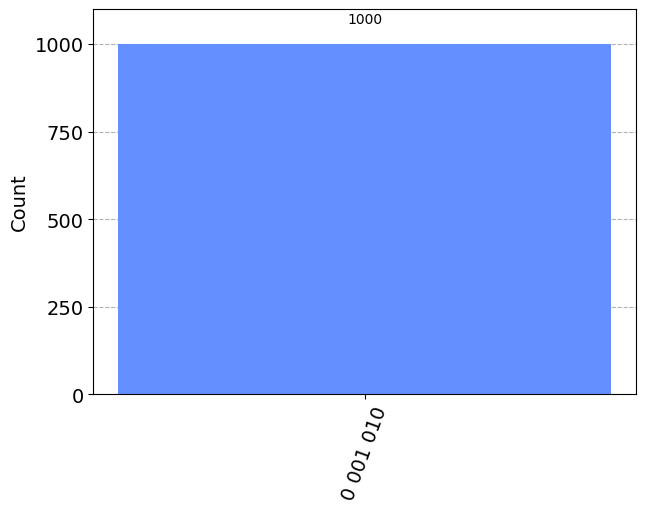

In [20]:
job = execute(test_circuit, Aer.get_backend('aer_simulator'), shots=1000)
results = job.result()
counts = results.get_counts()
print(counts)
# print(counts)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [21]:
bit_length = 4

carry_register = QuantumRegister(1, name="c")
second_carry_register = QuantumRegister(1, name="c'")
first_number_register = QuantumRegister(bit_length, name="a")
second_number_register = QuantumRegister(bit_length, name="b")
ancilla_register = QuantumRegister(3, name="ancilla")
first_number_measurement = ClassicalRegister(bit_length, name="a_results")
second_number_measurement = ClassicalRegister(bit_length, name="b_results")
# carry_measurement = ClassicalRegister(1, name="c_results")
ancilla_measurement = ClassicalRegister(3, name="ancilla_results")


def loadNumber(circ: QuantumCircuit, register: QuantumRegister, number: int):
    number_in_binary = '0'*(register.size - len(bin(number)[2:])) + bin(number)[2:]
    for i in range(len(number_in_binary)):
        if number_in_binary[::-1][i] == '1':
            circ.x(register[i])

def ancilla_intepreter(ancilla_measuremnt, num_1, num_2):
    if ancilla_measuremnt == "100":
        return "equal"
    elif ancilla_measuremnt == "010":
        return "{} > {}".format(num_1, num_2)
    elif ancilla_measuremnt == "001":
        return "{} < {}".format(num_1, num_2)
    else:
        return "error"

def process_counts(counts):
    key = list(counts.keys())[0]
    key_parts = key.split(' ')
    first_num = int(key_parts[2], 2)
    second_num = int(key_parts[1], 2)
    ancilla = key_parts[0]
    comparison_result = ancilla_intepreter(ancilla, first_num, second_num)
    return first_num, second_num, comparison_result

for firstNumber in range(2 ** (bit_length-1)):
    for secondNumber in range(2 ** (bit_length-1)):
        circ = QuantumCircuit(
            first_number_register,
            second_number_register,
            carry_register,
            second_carry_register,
            ancilla_register,
            first_number_measurement,
            second_number_measurement,
            ancilla_measurement
        )
        # load first number
        loadNumber(circ, first_number_register, firstNumber)
        # load second number
        loadNumber(circ, second_number_register, secondNumber)
        circ.append(
            QComp(bit_length, bit_length),
            first_number_register[:]
            + second_number_register[:]
            + carry_register[:]
            + ancilla_register[:],
        )
        circ.barrier()
        # adder = build_QNMAdd(3, 3)
        adder = DraperQFTAdder(bit_length, kind="half")
        circ.append(
            adder, first_number_register[:] + second_number_register[:] + second_carry_register[:]
        )
        # test_circuit.measure(first_number_register[:] + second_number_register[:] + carry_register[:], work_register_measurement[:])
        circ.measure(first_number_register[:], first_number_measurement[:])
        circ.measure(second_number_register[:], second_number_measurement[:])
        circ.measure(ancilla_register[:], ancilla_measurement[:])
        job = execute(circ, Aer.get_backend("qasm_simulator"), shots=1000)
        counts = job.result().get_counts()
        firstNumber, secondNumber, comparison_result = process_counts(counts)
        print("{}, {} ".format(firstNumber, secondNumber), comparison_result)

0, 0  equal


/tmp/ipykernel_3355492/3137124038.py:72: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  job = execute(circ, Aer.get_backend("qasm_simulator"), shots=1000)


0, 1  0 < 1
0, 2  0 < 2
0, 3  0 < 3
0, 4  0 < 4
0, 5  0 < 5
0, 6  0 < 6
0, 7  0 < 7
1, 0  1 > 0
1, 1  equal
1, 2  1 < 2
1, 3  1 < 3
1, 4  1 < 4
1, 5  1 < 5
1, 6  1 < 6
1, 7  1 < 7
2, 0  2 > 0
2, 1  2 > 1
2, 2  equal
2, 3  2 < 3
2, 4  2 < 4
2, 5  2 < 5
2, 6  2 < 6
2, 7  2 < 7
3, 0  3 > 0
3, 1  3 > 1
3, 2  3 > 2
3, 3  equal
3, 4  3 < 4
3, 5  3 < 5
3, 6  3 < 6
3, 7  3 < 7
4, 0  4 > 0
4, 1  4 > 1
4, 2  4 > 2
4, 3  4 > 3
4, 4  equal
4, 5  4 < 5
4, 6  4 < 6
4, 7  4 < 7
5, 0  5 > 0
5, 1  5 > 1
5, 2  5 > 2
5, 3  5 > 3
5, 4  5 > 4
5, 5  equal
5, 6  5 < 6
5, 7  5 < 7
6, 0  6 > 0
6, 1  6 > 1
6, 2  6 > 2
6, 3  6 > 3
6, 4  6 > 4
6, 5  6 > 5
6, 6  equal
6, 7  6 < 7
7, 0  7 > 0
7, 1  7 > 1
7, 2  7 > 2
7, 3  7 > 3
7, 4  7 > 4
7, 5  7 > 5
7, 6  7 > 6
7, 7  equal


# Check ancilla

# 2 stock call on max

In [22]:
# number of qubits to represent the uncertainty for our probability distribution
num_uncertainty_qubits = 3

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.5  # volatility of 40%
r = 0.05  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
# uncertainty_model = LogNormalDistribution(
#     num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
# )
uncertainty_model = LogNormalDistribution(
    num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
)

In [23]:
# import numpy as np
# from qiskit_finance.circuit.library import LogNormalDistribution
# # number of qubits per dimension to represent the uncertainty
# num_uncertainty_qubits = 3

# # parameters for considered random distribution
# S = 2.0  # initial spot price
# vol = 0.4  # volatility of 40%
# r = 0.04  # annual interest rate of 4%
# T = 40 / 365  # 40 days to maturity

# # resulting parameters for log-normal distribution
# mu = (r - 0.5 * vol**2) * T + np.log(S)
# sigma = vol * np.sqrt(T)
# mean = np.exp(mu + sigma**2 / 2)
# variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
# stddev = np.sqrt(variance)

# # lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
# low = np.maximum(0, mean - 3 * stddev)
# high = mean + 3 * stddev

# # map to higher dimensional distribution
# # for simplicity assuming dimensions are independent and identically distributed)
# dimension = 2
# num_qubits = [num_uncertainty_qubits] * dimension
# low = low * np.ones(dimension)
# high = high * np.ones(dimension)
# mu = mu * np.ones(dimension)
# cov = sigma**2 * np.eye(dimension) # covariance matrix

# uncertainty_model = LogNormalDistribution(num_qubits=num_qubits, mu=mu, sigma=cov, bounds=list(zip(low, high)))

In [25]:
from qiskit.circuit.library import LinearAmplitudeFunction
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 1.896

# set the approximation scaling for the payoff function
c_approx = 0.1

# setup piecewise linear objective fcuntion
breakpoints = [low, strike_price] 
# low is the lower bound, strike price is where our payoff function starts to increase
slopes = [0, 1]
# can be float or list of floats.
# for list of floats, the floats are the slopes of the individual linear functions

offsets = [0, 0]
# the offsets of each linear function
f_min = 0
# minimum y value
f_max = high - strike_price
# maximum y value

european_call_objective = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)
call_objective = european_call_objective.to_gate()

controlled_objective = call_objective.control(1)
# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
# num_qubits = european_call_objective.num_qubits
# european_call = QuantumCircuit(num_qubits)
# european_call.append(european_call_objective, range(num_qubits))
# european_call.draw()
controlled_objective.num_qubits

8

# full circuit

In [31]:

# number of qubits to represent the uncertainty for our probability distribution
num_uncertainty_qubits = 3

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.05  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
# uncertainty_model = LogNormalDistribution(
#     num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
# )
uncertainty_model = LogNormalDistribution(
    num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
)

In [33]:
from qiskit.circuit.library import LinearAmplitudeFunction
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 1.5
print(low)
print(high)

# set the approximation scaling for the payoff function
c_approx = 0.1

# setup piecewise linear objective fcuntion
breakpoints = [low, strike_price] 
# low is the lower bound, strike price is where our payoff function starts to increase
slopes = [0, 1]
# can be float or list of floats.
# for list of floats, the floats are the slopes of the individual linear functions

offsets = [0, 0]
# the offsets of each linear function
f_min = 0
# minimum y value
f_max = high - strike_price
# maximum y value

european_call_objective = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)
call_objective = european_call_objective.to_gate()

controlled_objective = call_objective.control(1)
# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
# num_qubits = european_call_objective.num_qubits
# european_call = QuantumCircuit(num_qubits)
# european_call.append(european_call_objective, range(num_qubits))
# european_call.draw()
controlled_objective.num_qubits

1.208607238741425
2.813370728095958


8

In [40]:
[round(step/10 * (0.9*high-1.1*low) + 1.1*low, 2) for step in range(10)]

[1.33, 1.45, 1.57, 1.69, 1.81, 1.93, 2.05, 2.17, 2.29, 2.41]

In [34]:
bit_length = num_uncertainty_qubits+1

carry_register = QuantumRegister(1, name='c')
second_carry_register = QuantumRegister(1, name='c\'')
first_number_register = QuantumRegister(bit_length, name='a')
second_number_register = QuantumRegister(bit_length, name='b')
objective_register = QuantumRegister(1, name='objective')
ancilla_register = QuantumRegister(3, name='ancilla')
second_ancilla_register = QuantumRegister(num_uncertainty_qubits, name='objective_ancilla')

adder = DraperQFTAdder(bit_length, kind="half")

circuit = QuantumCircuit(first_number_register, second_number_register, carry_register, second_carry_register, objective_register, ancilla_register, second_ancilla_register)
circuit.append(uncertainty_model, first_number_register[:-1])
circuit.append(uncertainty_model, second_number_register[:-1])
qcomp = QComp(bit_length,bit_length)
circuit.append(qcomp, first_number_register[:] + second_number_register[:] + carry_register[:] + ancilla_register[:])

circuit.append(adder, first_number_register[:] + second_number_register[:]+ second_carry_register[:])
circuit.append(controlled_objective, [ancilla_register[0]]+ second_number_register[:-1] + objective_register[:]+ second_ancilla_register[:])
circuit.append(controlled_objective, [ancilla_register[1]]+ first_number_register[:-1] + objective_register[:] + second_ancilla_register[:])
circuit.append(controlled_objective, [ancilla_register[2]]+ first_number_register[:-1] + objective_register[:] + second_ancilla_register[:])

circuit.draw()

┌───────┐┌─────────┐┌─────────────────┐      ┌────┐┌────┐
                a_0: ┤0      ├┤0        ├┤0                ├──────┤0   ├┤0   ├
                     │       ││         ││                 │      │    ││    │
                a_1: ┤1 P(X) ├┤1        ├┤1                ├──────┤1   ├┤1   ├
                     │       ││         ││                 │      │    ││    │
                a_2: ┤2      ├┤2        ├┤2                ├──────┤2   ├┤2   ├
                     └───────┘│         ││                 │      │    ││    │
                a_3: ─────────┤3        ├┤3                ├──────┤    ├┤    ├
                     ┌───────┐│         ││                 │┌────┐│    ││    │
                b_0: ┤0      ├┤4        ├┤4                ├┤0   ├┤    ├┤    ├
                     │       ││         ││  DraperQFTAdder ││    ││    ││    │
                b_1: ┤1 P(X) ├┤5        ├┤5                ├┤1   ├┤    ├┤    ├
                     │       ││         ││                 ││    ││    ││    │
                b_2: ┤2      ├┤6        ├┤6                ├┤2   ├┤    ├┤    ├
                     └───────┘│   QComp ││                 ││    ││    ││    │
                b_3: ─────────┤7        ├┤7                ├┤    ├┤    ├┤    ├
                              │         ││                 ││    ││    ││    │
                  c: ─────────┤8        ├┤                 ├┤    ├┤  F ├┤  F ├
                              │         ││                 ││    ││    ││    │
                 c': ─────────┤         ├┤8                ├┤    ├┤    ├┤    ├
                              │         │└─────────────────┘│    ││    ││    │
          objective: ─────────┤         ├───────────────────┤3 F ├┤3   ├┤3   ├
                              │         │                   │    ││    ││    │
          ancilla_0: ─────────┤9        ├───────────────────■    ├┤    ├┤    ├
                              │         │                   │    ││    ││    │
          ancilla_1: ─────────┤10       ├───────────────────┤    ├■    ├┤    ├
                              │         │                   │    ││    ││    │
          ancilla_2: ─────────┤11       ├───────────────────┤    ├┤    ├■    ├
                              └─────────┘                   │    ││    ││    │
objective_ancilla_0: ───────────────────────────────────────┤4   ├┤4   ├┤4   ├
                                                            │    ││    ││    │
objective_ancilla_1: ───────────────────────────────────────┤5   ├┤5   ├┤5   ├
                                                            │    ││    ││    │
objective_ancilla_2: ───────────────────────────────────────┤6   ├┤6   ├┤6   ├
                                                            └────┘└────┘└────┘

In [39]:
probability_dist = []
value_map = []
for i in range(len(uncertainty_model.probabilities)):
    for j in range(len(uncertainty_model.probabilities)):
        probability_dist.append(uncertainty_model.probabilities[i]*uncertainty_model.probabilities[j])
        value_map.append([uncertainty_model.values[i], uncertainty_model.values[j]])
exact_value = 0
for i in range(len(probability_dist)):
    exact_value += probability_dist[i]*max(0, max(value_map[i][0], value_map[i][1])-strike_price)

print("exact expected value:\t%.4f" % exact_value)

exact expected value:	0.6533


In [36]:
# set target precision and confidence level
from qiskit.utils import QuantumInstance
from qiskit_aer import AerSimulator
from ModifiedIQAE.algorithms.amplitude_estimators.mod_iae import ModifiedIterativeAmplitudeEstimation
from qiskit_algorithms import EstimationProblem
from qiskit_algorithms import IterativeAmplitudeEstimation
from qiskit_aer.primitives import Sampler

epsilon = 0.01
alpha = 0.005

problem = EstimationProblem(
    state_preparation=circuit,
    objective_qubits=[10],
    post_processing=european_call_objective.post_processing,
)
# construct amplitude estimation

qi = QuantumInstance(backend=AerSimulator(), shots=1000)
ae = ModifiedIterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, quantum_instance=qi)
result = ae.estimate(problem, shots=1000)

ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 100000})
)
result = ae.estimate(problem)

/tmp/ipykernel_3355492/2363895980.py:17: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed in the Qiskit 1.0 release. For code migration guidelines, visit https://qisk.it/qi_migration.
  qi = QuantumInstance(backend=AerSimulator(), shots=1000)


In [37]:
print(result)

{   'alpha': 0.005,
    'circuit_results': None,
    'confidence_interval': (0.4922693538406147, 0.5056117977734849),
    'confidence_interval_processed': (0.5920480574678127, 0.7036066026704797),
    'epsilon_estimated': 0.006671221966435076,
    'epsilon_estimated_processed': 0.055779272601333474,
    'epsilon_target': None,
    'estimate_intervals': [   [0.0, 1.0],
                              [0.4528971229535401, 0.5826863325404233],
                              [0.4922693538406147, 0.5056117977734849]],
    'estimation': 0.49894057580704976,
    'estimation_processed': 0.647827330069146,
    'num_oracle_queries': 9001,
    'powers': [0, 4, 4],
    'ratios': [9.0, 1.0],
    'shots': None,
    'theta_intervals': [   [0, 1],
                           [0.46996884522868004, 0.5528826889906704],
                           [0.49507832169932875, 0.5035726564311902]]}


In [38]:
conf_int = (
    np.array(result.confidence_interval_processed)
)
print(
    "Estimated value:    \t%.4f"
    % (result.estimation_processed)
)
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Estimated value:    	0.6478
Confidence interval:	[0.5920, 0.7036]


## Call-on-min

In [30]:
import numpy as np
from qiskit_finance.circuit.library import LogNormalDistribution
# number of qubits to represent the uncertainty for our probability distribution
num_uncertainty_qubits = 3

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.05  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
# uncertainty_model = LogNormalDistribution(
#     num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
# )
uncertainty_model = LogNormalDistribution(
    num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
)

In [31]:
from qiskit.circuit.library import LinearAmplitudeFunction
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 1.896

# set the approximation scaling for the payoff function
c_approx = 0.125

# setup piecewise linear objective fcuntion
breakpoints = [low, strike_price] 
# low is the lower bound, strike price is where our payoff function starts to increase
slopes = [-1, 0]
# can be float or list of floats.
# for list of floats, the floats are the slopes of the individual linear functions

offsets = [strike_price - low, 0]
# the offsets of each linear function
f_min = 0
# minimum y value
f_max = strike_price - low
# maximum y value

european_call_objective = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)
call_objective = european_call_objective.to_gate()

controlled_objective = call_objective.control(1)
# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
# num_qubits = european_call_objective.num_qubits
# european_call = QuantumCircuit(num_qubits)
# european_call.append(european_call_objective, range(num_qubits))
# european_call.draw()
controlled_objective.num_qubits

8

In [32]:
bit_length = num_uncertainty_qubits+1

carry_register = QuantumRegister(1, name='c')
second_carry_register = QuantumRegister(1, name='c\'')
first_number_register = QuantumRegister(bit_length, name='a')
second_number_register = QuantumRegister(bit_length, name='b')
objective_register = QuantumRegister(1, name='objective')
ancilla_register = QuantumRegister(3, name='ancilla')
second_ancilla_register = QuantumRegister(num_uncertainty_qubits, name='objective_ancilla')

adder = DraperQFTAdder(bit_length, kind="half")

circuit = QuantumCircuit(first_number_register, second_number_register, carry_register, second_carry_register, objective_register, ancilla_register, second_ancilla_register)
circuit.append(uncertainty_model, first_number_register[:-1])
circuit.append(uncertainty_model, second_number_register[:-1])
qcomp = QComp(bit_length,bit_length)
circuit.append(qcomp, first_number_register[:] + second_number_register[:] + carry_register[:] + ancilla_register[:])

circuit.append(adder, first_number_register[:] + second_number_register[:]+ second_carry_register[:])
circuit.append(controlled_objective, [ancilla_register[0]]+ first_number_register[:-1] + objective_register[:]+ second_ancilla_register[:])
circuit.append(controlled_objective, [ancilla_register[1]]+ second_number_register[:-1] + objective_register[:] + second_ancilla_register[:])
circuit.append(controlled_objective, [ancilla_register[2]]+ second_number_register[:-1] + objective_register[:] + second_ancilla_register[:])

circuit.draw()

┌───────┐┌─────────┐┌─────────────────┐┌────┐            
                a_0: ┤0      ├┤0        ├┤0                ├┤0   ├────────────
                     │       ││         ││                 ││    │            
                a_1: ┤1 P(X) ├┤1        ├┤1                ├┤1   ├────────────
                     │       ││         ││                 ││    │            
                a_2: ┤2      ├┤2        ├┤2                ├┤2   ├────────────
                     └───────┘│         ││                 ││    │            
                a_3: ─────────┤3        ├┤3                ├┤    ├────────────
                     ┌───────┐│         ││                 ││    │┌────┐┌────┐
                b_0: ┤0      ├┤4        ├┤4                ├┤    ├┤0   ├┤0   ├
                     │       ││         ││  DraperQFTAdder ││    ││    ││    │
                b_1: ┤1 P(X) ├┤5        ├┤5                ├┤    ├┤1   ├┤1   ├
                     │       ││         ││                 ││    ││    ││    │
                b_2: ┤2      ├┤6        ├┤6                ├┤    ├┤2   ├┤2   ├
                     └───────┘│   QComp ││                 ││    ││    ││    │
                b_3: ─────────┤7        ├┤7                ├┤    ├┤    ├┤    ├
                              │         ││                 ││    ││    ││    │
                  c: ─────────┤8        ├┤                 ├┤  F ├┤    ├┤    ├
                              │         ││                 ││    ││    ││    │
                 c': ─────────┤         ├┤8                ├┤    ├┤    ├┤    ├
                              │         │└─────────────────┘│    ││    ││    │
          objective: ─────────┤         ├───────────────────┤3   ├┤3 F ├┤3 F ├
                              │         │                   │    ││    ││    │
          ancilla_0: ─────────┤9        ├───────────────────■    ├┤    ├┤    ├
                              │         │                   │    ││    ││    │
          ancilla_1: ─────────┤10       ├───────────────────┤    ├■    ├┤    ├
                              │         │                   │    ││    ││    │
          ancilla_2: ─────────┤11       ├───────────────────┤    ├┤    ├■    ├
                              └─────────┘                   │    ││    ││    │
objective_ancilla_0: ───────────────────────────────────────┤4   ├┤4   ├┤4   ├
                                                            │    ││    ││    │
objective_ancilla_1: ───────────────────────────────────────┤5   ├┤5   ├┤5   ├
                                                            │    ││    ││    │
objective_ancilla_2: ───────────────────────────────────────┤6   ├┤6   ├┤6   ├
                                                            └────┘└────┘└────┘

In [33]:
probability_dist = []
value_map = []
for i in range(len(uncertainty_model.probabilities)):
    for j in range(len(uncertainty_model.probabilities)):
        probability_dist.append(uncertainty_model.probabilities[i]*uncertainty_model.probabilities[j])
        value_map.append([uncertainty_model.values[i], uncertainty_model.values[j]])
exact_value = 0
for i in range(len(probability_dist)):
    exact_value += probability_dist[i]*max(0, strike_price - min(value_map[i][0], value_map[i][1]))

print("exact expected value:\t%.4f" % exact_value)

exact expected value:	0.0896


In [34]:
# set target precision and confidence level
from qiskit.utils import QuantumInstance
from qiskit_aer import AerSimulator
from ModifiedIQAE.algorithms.amplitude_estimators.mod_iae import ModifiedIterativeAmplitudeEstimation
from qiskit_algorithms import EstimationProblem

epsilon = 0.01
alpha = 0.005

problem = EstimationProblem(
    state_preparation=circuit,
    objective_qubits=[10],
    post_processing=european_call_objective.post_processing,
)
# construct amplitude estimation

qi = QuantumInstance(backend=AerSimulator(), shots=200)
ae = ModifiedIterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, quantum_instance=qi)
result = ae.estimate(problem, shots=200)

/var/folders/1b/41tf8c954h79vyg2kpcm8cqc0000gn/T/ipykernel_9676/1999716380.py:17: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  qi = QuantumInstance(backend=AerSimulator(), shots=200)


In [35]:
conf_int = (
    np.array(result.confidence_interval_processed)
)
print(
    "Estimated value:    \t%.4f"
    % (result.estimation_processed)
)
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Estimated value:    	0.0919
Confidence interval:	[0.0740, 0.1097]


## Best-of-calls